### Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
from Bio import AlignIO
from Bio.Align import substitution_matrices
from Bio.Data import IUPACData
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.SeqRecord import SeqRecord
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

import cafaeval
from cafaeval.evaluation import cafa_eval
from cafaeval.parser import obo_parser, gt_parser

from pathlib import Path
import os

import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


c:\ProgramData\anaconda3\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Creating the path to the main folder we are going to use to create our datasets

In [2]:
# Path to train data
training_data_path = Path('../data/train')

# Path to test data
test_data_path = Path('../data/test')

# Path to baseline data
baseline_data_path = Path('../data/baseline')

# Path tp output folder
output_folder = Path('../output')

# Training Set

In this section we are **creating the Training Set**, fusing togheter the data from:
- _train_set.tsv_
- _train_ids.txt_
- _train.fasta_
- _train_embeddings.h5_
- _train_protein2ipr.dat_
- _go-basic.obo_

### Extracting `train_set.tsv`

In [3]:
train_set = pd.read_csv(training_data_path / 'train_set.tsv', sep='\t')

# Rename Protein_ID and aspect columns
train_set.rename(columns={'Protein_ID': 'ID', 'aspect' : 'sub_ontology'}, inplace=True)

# Display the first few rows of the train set
train_set.head()

,ID,sub_ontology,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


### Extracting `train_ids.txt`

In [4]:
# Extracting train_ids.txt
with open(training_data_path / 'train_ids.txt', 'r') as file:
    train_ids = file.read().splitlines()

# Display the first few IDs to verify
print(train_ids[:5])

['P91124', 'Q55DL5', 'O81027', 'Q04418', 'Q8IXT2']


In [5]:
if len(train_ids) == len(train_set['ID'].unique()):
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(train_ids)}).\n"
          "Proceeding with the analysis.")

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (123969).
Proceeding with the analysis.


### Extracting `train.fasta`

In [6]:
train_fasta_list = list(SeqIO.parse(training_data_path / 'train.fasta', 'fasta'))

# Print the first sequence to verify
print(train_fasta_list[0])

ID: P91124
Name: P91124
Description: P91124
Number of features: 0
Seq('MAAQFYERNTSGMNADRFMTRLTDESTVNTMQRHYWTARQFIRTKLGKKEDEHL...NLL')


Let's transform it into a DataFrame

In [7]:
# Extract relevant information from SeqRecord
train_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in train_fasta_list]

# Create a DataFrame from the extracted data
train_fasta = pd.DataFrame(train_fasta_dict)

# Display the DataFrame
train_fasta.head()

,ID,name,description,num_features,sequence
0,P91124,P91124,P91124,0,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,Q55DL5,Q55DL5,0,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,O81027,O81027,0,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,Q04418,Q04418,0,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,Q8IXT2,Q8IXT2,0,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


Checking if `ID`, `name` and `description` have the same information

In [8]:
# Checking for differences between the ID and name columns
diff_id_name = sum(train_fasta['ID'] != train_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(train_fasta['ID'] != train_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


Checking if `num_features` has value different from 0

In [9]:
num_features_values = sum(train_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


**Nice!**

We found that `ID`, `name` and `description` columns are the same. We can remove two of them (`name`, `descritpion`). 

In the same way we saw that `num_features` is not very informative since it has only 0, let's remove it as well



In [10]:
train_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


train_fasta.head()

,ID,sequence
0,P91124,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


### Extracting `train_embeddings.h5`

In [11]:
filename = "train_embeddings.h5"

data_list = []

with h5py.File(training_data_path / filename, "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

train_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

train_embeddings.head()

,ID,embeddings
0,A0A009IHW8,"[0.0682, -0.04648, 0.001752, -0.00858, 0.00376..."
1,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243..."
2,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788..."
3,A0A023FBW4,"[0.002447, 0.007053, 0.06445, 0.00727, -0.0335..."
4,A0A023FBW7,"[0.04932, 0.02069, 0.10864, 0.01634, -0.05106,..."


In [12]:
train_embeddings_np = np.array(train_embeddings['embeddings'].tolist())
print(train_embeddings_np.shape)

(123969, 1024)


### Extracting `train_protein2ipr.dat`

In [13]:
train_protein2ipr = pd.read_csv(training_data_path / 'train_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
train_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Display the first few rows of the train set
train_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,PS50104,133,266
1,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,SM00255,134,258
2,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,G3DSA:3.40.50.10140,80,266
3,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,SSF52200,128,249
4,A0A021WW32,IPR006910,"Rad21/Rec8-like protein, N-terminal",PF04825,1,103


In [14]:
# Group by 'ID' and aggregate other columns into lists
train_protein2ipr_grouped = train_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Train protein2ipr ({train_protein2ipr.shape}):")
train_protein2ipr_grouped.head()

Train protein2ipr ((1103545, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,"(IPR000157, IPR000157, IPR035897, IPR035897)",(Toll/interleukin-1 receptor homology (TIR) do...,"(PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)","(133, 134, 80, 128)","(266, 258, 266, 249)"
1,A0A021WW32,"(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
2,A0A021WZA4,"(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
3,A0A023FBW7,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"
4,A0A023FDY8,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"


Still have to understand what *tizio, caio, sempronio* are.

### Extracting `go-basic.obo`

In [15]:
import re

file_path = "../data/train/go-basic.obo"  # Replace with your file path

# Step 1: Initialize storage for GO terms
go_terms = []

# Step 2: Parse the .obo file
with open(file_path, 'r') as file:
    current_term = {}
    for line in file:
        line = line.strip()
        
        # Start of a new term
        if line == "[Term]":
            if current_term:  # Save the previous term
                go_terms.append(current_term)
            current_term = {}  # Start a new term
            
        elif line.startswith("id:"):
            current_term['ID'] = line.split("id: ")[1]
            
        elif line.startswith("alt_id:"):
            alt_id = line.split("alt_id: ")[1]
            current_term.setdefault('alt_ids', []).append(alt_id)
            
        elif line.startswith("name:"):
            current_term['name'] = line.split("name: ")[1]
            
        elif line.startswith("namespace:"):
            current_term['namespace'] = line.split("namespace: ")[1]
            
        elif line.startswith("is_a"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                is_a_id = match.group()
                current_term.setdefault('is_a', []).append(is_a_id)
                
        elif line.startswith("relationship: part_of"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                part_of_id = match.group()
                current_term.setdefault('part_of', []).append(part_of_id)

            
    # Add the last term
    if current_term:
        go_terms.append(current_term)

# Step 3: Create a unified list of all IDs (primary and alt_ids)
expanded_terms = []
for term in go_terms:
    primary_id = term['ID']
    alt_ids = term.get('alt_ids', [])
    all_ids = [primary_id] + alt_ids
    
    for term_id in all_ids:
        expanded_terms.append({
            'ID': term_id,
            'name': term.get('name'),
            'namespace': term.get('namespace'),
            'is_a': term.get('is_a', []),
            'part_of': term.get('part_of', [])
        })

# Step 4: Convert to a DataFrame
df = pd.DataFrame(expanded_terms)

# Step 5: Filter by namespace and explode relationships
df_is_a = df.explode('is_a').dropna(subset=['is_a'])
df_part_of = df.explode('part_of').dropna(subset=['part_of'])


print("All IDs with namespaces:")
df.head()

All IDs with namespaces:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,"[GO:0048308, GO:0048311]",[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,[GO:0007005],[]
2,GO:0000003,reproduction,biological_process,[GO:0008150],[]
3,GO:0019952,reproduction,biological_process,[GO:0008150],[]
4,GO:0050876,reproduction,biological_process,[GO:0008150],[]


In [16]:
print("'is_a' relationships:")
df_is_a.head()

'is_a' relationships:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048308,[]
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048311,[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,GO:0007005,[]
2,GO:0000003,reproduction,biological_process,GO:0008150,[]
3,GO:0019952,reproduction,biological_process,GO:0008150,[]


In [17]:
print("'part_of' relationships:")
df_part_of.head()

'part_of' relationships:


,ID,name,namespace,is_a,part_of
16,GO:0000015,phosphopyruvate hydratase complex,cellular_component,[GO:1902494],GO:0005829
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052


## Merging all previous extractions

Let us collect the dataframes and check lengths. Noting that:
- _train_set.tsv_ contains the proteins, their GO annotations and their corresponding aspects which will be used to subdivde it into three separate datasets
- _train.fasta_ and _train_embeddings.h5_ can be grouped together since they refers to the whole input
- _train_protein2ipr.dat_
- _go-basic.obo_

In [18]:
def group_and_combine(df, sub_ontology_value):
    return df[df['sub_ontology'] == sub_ontology_value].groupby('ID')['GO_term'].apply(tuple).reset_index()

# Create three dataframes for each sub_ontology value
df_CC = group_and_combine(train_set, 'cellular_component')
df_MF = group_and_combine(train_set, 'molecular_function')
df_BP = group_and_combine(train_set, 'biological_process')

print(f"Shapes: CC {df_CC.shape}, MF {df_MF.shape}, BP {df_BP.shape}")

print(f"Cellular Component ({df_CC.shape[0]}):")
df_CC.head()

Shapes: CC (84638, 2), MF (55698, 2), BP (83064, 2)
Cellular Component (84638):


,ID,GO_term
0,A0A021WW32,"(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [19]:
## TRY NOT COMBINE EMBEDDINGS
# combined_train = pd.merge(train_embeddings, train_fasta, on='ID')
# combined_train = pd.merge(combined_train, train_protein2ipr_grouped, on='ID', how='left')

combined_train = pd.merge(train_fasta, train_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_train[combined_train['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

# combined_train = combined_train.drop('domain', axis=1)

print(f"Combined DataFrame shape: {combined_train.shape}")
combined_train.head()

Number of rows missing from train_protein2ipr_grouped: 6522
Combined DataFrame shape: (123969, 7)


,ID,sequence,ipr,domain,familyID,start,end
0,P91124,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ...","(IPR010504, IPR010504, IPR010504, IPR024114, I...","(Arfaptin homology (AH) domain, Arfaptin homol...","(PF06456, PS50870, SM01015, PTHR10164, G3DSA:1...","(28, 56, 27, 15, 54, 56)","(255, 260, 255, 329, 257, 256)"
1,Q55DL5,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ...","(IPR001841, IPR001841, IPR011990, IPR011990, I...","(Zinc finger, RING-type, Zinc finger, RING-typ...","(PS50089, SM00184, G3DSA:1.25.40.10, SSF48452,...","(13, 13, 74, 84, 3, 28, 13, 156, 121, 83, 121,...","(52, 51, 221, 186, 73, 37, 51, 182, 154, 116, ..."
2,O81027,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ...","(IPR000891, IPR000891, IPR013785, IPR043594)","(Pyruvate carboxyltransferase, Pyruvate carbox...","(PF00682, PS50991, G3DSA:3.20.20.70, PTHR42738)","(168, 168, 162, 151)","(441, 435, 461, 459)"
3,Q04418,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ...","(IPR013929, IPR013930, IPR039913)","(RNA polymerase II-associated protein 1, C-ter...","(PF08620, PF08621, PTHR21483)","(289, 79, 4)","(356, 123, 364)"
4,Q8IXT2,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ...","(IPR001275, IPR001275, IPR001275, IPR001275, I...","(DM DNA-binding domain, DM DNA-binding domain,...","(PF00751, PS40000, PS50809, SM00301, PTHR12322...","(38, 42, 42, 38, 1, 240, 35, 37)","(84, 71, 89, 91, 357, 366, 84, 84)"


In [20]:
# Merge combined_train with df_ab
df_CC_full= pd.merge(combined_train, df_CC, on='ID', how='right')
df_MF_full= pd.merge(combined_train, df_MF, on='ID', how='right')
df_BP_full= pd.merge(combined_train, df_BP, on='ID', how='right')

print(f"Shapes: CC {df_CC_full.shape}, MF {df_MF_full.shape}, BP {df_BP_full.shape}")

print(f"Full df CC {df_CC_full.shape}:")
df_CC_full.head()

Shapes: CC (84638, 8), MF (55698, 8), BP (83064, 8)
Full df CC (84638, 8):


,ID,sequence,ipr,domain,familyID,start,end,GO_term
0,A0A021WW32,"(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)","(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)","(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100...","(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)","(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3...","(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [21]:
x_df_CC = df_CC_full.iloc[:, :-1]
y_df_CC = df_CC_full.iloc[:, -1]
x_df_MF = df_MF_full.iloc[:, :-1]
y_df_MF = df_MF_full.iloc[:, -1]
x_df_BP = df_BP_full.iloc[:, :-1]
y_df_BP = df_BP_full.iloc[:, -1]

print(f"Shapes: x_df_CC {x_df_CC.shape}, y_df_CC {y_df_CC.shape}, x_df_MF {x_df_MF.shape}, y_df_MF {y_df_MF.shape}, x_df_BP {x_df_BP.shape}, y_df_BP {y_df_BP.shape}")

print("CC Input:")
x_df_CC.head()

Shapes: x_df_CC (84638, 7), y_df_CC (84638,), x_df_MF (55698, 7), y_df_MF (55698,), x_df_BP (83064, 7), y_df_BP (83064,)
CC Input:


,ID,sequence,ipr,domain,familyID,start,end
0,A0A021WW32,"(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
1,A0A021WZA4,"(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
2,A0A023GPJ3,"(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100..."
3,A0A023GUT0,"(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)"
4,A0A023IM54,"(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3..."


In [22]:
print("CC Target:")
y_df_CC.head()

CC Target:


0    (GO:0005575, GO:0110165, GO:0000785, GO:003299...
1    (GO:0005575, GO:0110165, GO:0071944, GO:000588...
2    (GO:0005575, GO:0110165, GO:0005622, GO:000582...
3     (GO:0005575, GO:0110165, GO:0005576, GO:0005615)
4    (GO:0005575, GO:0005737, GO:0042175, GO:003299...
Name: GO_term, dtype: object

In [23]:
# Filter the IDs based on sub_ontology
cc_ids = train_set[train_set['sub_ontology'] == 'cellular_component']['ID'].unique()
mf_ids = train_set[train_set['sub_ontology'] == 'molecular_function']['ID'].unique()
bp_ids = train_set[train_set['sub_ontology'] == 'biological_process']['ID'].unique()

# Create a dictionary to map IDs to their index in train_embeddings
id_to_index = {id_: idx for idx, id_ in enumerate(train_embeddings['ID'])}

# Get the indices for each sub_ontology
cc_indices = [id_to_index[id_] for id_ in cc_ids if id_ in id_to_index]
mf_indices = [id_to_index[id_] for id_ in mf_ids if id_ in id_to_index]
bp_indices = [id_to_index[id_] for id_ in bp_ids if id_ in id_to_index]

# Create the numpy matrices
x_emb_CC = train_embeddings_np[cc_indices]
x_emb_MF = train_embeddings_np[mf_indices]
x_emb_BP = train_embeddings_np[bp_indices]

print(f"x_emb_CC shape: {x_emb_CC.shape}")
print(f"x_emb_MF shape: {x_emb_MF.shape}")
print(f"x_emb_BP shape: {x_emb_BP.shape}")

x_emb_CC shape: (84638, 1024)
x_emb_MF shape: (55698, 1024)
x_emb_BP shape: (83064, 1024)


Now, let us export the dataframe so that we don't have to run this code each time.

In [24]:
import filecmp

# Function to export DataFrame to CSV with check
def export_dataframe(df, filename, check=False):
    output_path = output_folder / filename
    temp_path = output_folder / f'temp_{filename}'
    
    # Save DataFrame to a temporary file
    df.to_csv(temp_path, index=False)
    
    # Check if the file already exists
    if output_path.exists():
        # Compare the temporary file with the existing file
        if filecmp.cmp(temp_path, output_path, shallow=False):
            print(f"{filename} is already up-to-date.")
            temp_path.unlink()  # Remove the temporary file
        else:
            if check:
                # Ask the user if they want to overwrite the file
                response = input(f"{filename} already exists and is different. Do you want to overwrite it? (yes/no): ")
            if not check or response.lower() == 'yes':
                os.remove(output_path)
                temp_path.rename(output_path)
                print(f"{filename} has been overwritten.")
            else:
                temp_path.unlink()  # Remove the temporary file
                print(f"{filename} has not been overwritten.")
    else:
        temp_path.rename(output_path)
        print(f"{filename} has been created.")

# Export DataFrames to CSV files with check
#export_dataframe(x_df_CC, 'x_df_CC.csv')
#export_dataframe(y_df_CC, 'y_df_CC.csv')
#export_dataframe(x_df_MF, 'x_df_MF.csv')
#export_dataframe(y_df_MF, 'y_df_MF.csv')
#export_dataframe(x_df_BP, 'x_df_BP.csv')
#export_dataframe(y_df_BP, 'y_df_BP.csv')

print("DataFrames have been exported successfully.")

DataFrames have been exported successfully.


In [25]:
# Function to export numpy array to .npy file
def export_numpy_array(np_array, filename):
    output_path = output_folder / filename
    np.save(output_path, np_array)
    print(f"{filename} has been created.")

### Export numpy arrays to .npy files
#export_numpy_array(x_emb_CC, 'x_emb_CC.npy')
#export_numpy_array(x_emb_MF, 'x_emb_MF.npy')
#export_numpy_array(x_emb_BP, 'x_emb_BP.npy')

print("Numpy arrays have been exported successfully.")

Numpy arrays have been exported successfully.


# Test set

In this section we are **creating the Test set**, fusing togheter the data from:
- _test_ids.txt_
- _test.fasta_
- _test_embeddings.h5_
- _test_protein2ipr.dat_
- _blast_test_results.tsv_

### Extracting `test_ids.txt`

In [26]:
# Extracting test_ids.txt
with open(test_data_path / 'test_ids.txt', 'r') as file:
    test_ids = file.read().splitlines()

# Display the first few IDs to verify
print(test_ids[:5])

['O43747', 'Q969H0', 'Q9JMA2', 'P18065', 'A0A8I6AN32']


### Extracting `test.fasta`

In [27]:
test_fasta_list = list(SeqIO.parse(test_data_path / 'test.fasta', 'fasta'))

# Print the first sequence to verify
print(test_fasta_list[0])

ID: O43747
Name: O43747
Description: O43747
Number of features: 0
Seq('MPAPIRLRELIRTIRTARTQAEEREMIQKECAAIRSSFREEDNTYRCRNVAKLL...SWQ')


In [28]:
# Extract relevant information from SeqRecord
test_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in test_fasta_list]

# Create a DataFrame from the extracted data
test_fasta = pd.DataFrame(test_fasta_dict)

# Display the DataFrame
test_fasta.head()

,ID,name,description,num_features,sequence
0,O43747,O43747,O43747,0,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,Q969H0,Q969H0,0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,Q9JMA2,Q9JMA2,0,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,P18065,P18065,0,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,A0A8I6AN32,A0A8I6AN32,0,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's check if ID, name and description are the same thing, as well as seeing if num_features has relevant information.

In [29]:
# Checking for differences between the ID and name columns
diff_id_name = sum(test_fasta['ID'] != test_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(test_fasta['ID'] != test_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


In [30]:
num_features_values = sum(test_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


Let's drop the useless columns, as before

In [31]:
test_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


test_fasta.head()

,ID,sequence
0,O43747,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's also check if the IDs are the same as the ones in the txt file

In [32]:
len_ID = len(test_fasta['ID'].unique()) # assigned because gave problem on else statement print

if len(test_ids) == len_ID:
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(test_ids)}).\n"
          "Proceeding with the analysis.")
else:
    print(f'The numbers are not the same: test_ids are {len(test_ids)}, while the length of the fasta file is {len_ID})')

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (1000).
Proceeding with the analysis.


### Extracting `test_embeddings.h5`

In [33]:
data_list = []

with h5py.File(test_data_path / "test_embeddings.h5", "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

test_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

test_embeddings.head()

,ID,embeddings
0,A0A0B4JCV4,"[0.00979, -0.03973, 0.03653, -0.006447, -0.040..."
1,A0A0B4KHT0,"[0.02786, -0.01154, 0.008865, -0.01765, 0.0073..."
2,A0A0B4P506,"[0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0..."
3,A0A0G2K1A2,"[0.00882, 0.0835, -0.001374, -0.0003645, -0.06..."
4,A0A0G2K1V4,"[0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0...."


In [34]:
test_embeddings_np = np.array(test_embeddings['embeddings'].tolist())
print(test_embeddings_np.shape)

(1000, 1024)


### Extracting `test_protein2ipr.dat`

In [35]:
test_protein2ipr = pd.read_csv(test_data_path / 'test_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
test_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Remove 'domain' that is useless
test_protein2ipr.drop('domain', axis=1)

test_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,IPR039915,TACC family,PTHR13924,38,1206
1,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,177,219
2,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,236,274
3,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,173,220
4,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,235,282


In [36]:
# Group by 'ID' and aggregate other columns into lists
test_protein2ipr_grouped = test_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Test protein2ipr ({test_protein2ipr.shape}):")
test_protein2ipr_grouped.head()

Test protein2ipr ((11263, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,"(IPR039915,)","(TACC family,)","(PTHR13924,)","(38,)","(1206,)"
1,A0A0B4KHT0,"(IPR000315, IPR000315, IPR000315, IPR000315, I...","(B-box-type zinc finger, B-box-type zinc finge...","(PF00643, PF00643, PS50119, PS50119, SM00336, ...","(177, 236, 173, 235, 173, 235, 976, 826, 988, ...","(219, 274, 220, 282, 220, 276, 1048, 839, 1004..."
2,A0A0B4P506,"(IPR003417, IPR003417, IPR036552, IPR036552)","(Core-binding factor, beta subunit, Core-bindi...","(PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)","(1, 1, 1, 4)","(164, 168, 142, 140)"
3,A0A0G2K1A2,"(IPR010255, IPR019791, IPR019791, IPR019791, I...","(Haem peroxidase superfamily, Haem peroxidase,...","(SSF48113, PF03098, PR00457, PR00457, PR00457,...","(142, 148, 172, 226, 374, 392, 417, 470, 598, ...","(718, 692, 183, 241, 392, 412, 443, 480, 618, ..."
4,A0A0G2K1V4,"(IPR000048, IPR000048, IPR001609, IPR001609, I...","(IQ motif, EF-hand binding site, IQ motif, EF-...","(PS50096, SM00015, PF00063, PR00193, PR00193, ...","(789, 788, 89, 116, 172, 228, 459, 513, 86, 80...","(818, 810, 774, 135, 197, 255, 487, 541, 786, ..."


### Extracting `blast_test_results.tsv`

### Merging

In [37]:
# combined_test = pd.merge(test_embeddings, test_fasta, on='ID')
# combined_test = pd.merge(combined_test, test_protein2ipr_grouped, on='ID', how='left')

combined_test = pd.merge(test_fasta, test_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_test[combined_test['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

print(f"Combined DataFrame shape: {combined_test.shape}")
combined_test.head()

Number of rows missing from train_protein2ipr_grouped: 19
Combined DataFrame shape: (1000, 7)


,ID,sequence,ipr,domain,familyID,start,end
0,O43747,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ...","(IPR002553, IPR008152, IPR008152, IPR008153, I...","(Clathrin/coatomer adaptor, adaptin-like, N-te...","(PF01602, PF02883, SM00809, PS50180, G3DSA:1.2...","(23, 706, 699, 702, 1, 695, 22, 3)","(573, 817, 817, 817, 588, 821, 599, 820)"
1,Q969H0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ...","(IPR001680, IPR001680, IPR001680, IPR001680, I...","(WD40 repeat, WD40 repeat, WD40 repeat, WD40 r...","(PF00400, PF00400, PF00400, PF00400, PF00400, ...","(373, 411, 451, 491, 532, 571, 611, 391, 417, ...","(407, 447, 487, 527, 567, 607, 650, 416, 456, ..."
2,Q9JMA2,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ...","(IPR002616, IPR002616, IPR004803, IPR004803, I...","(tRNA-guanine(15) transglycosylase-like, tRNA-...","(PF01702, TIGR00449, MF_00168, TIGR00430, G3DS...","(27, 22, 15, 21, 16, 22)","(380, 380, 379, 380, 382, 380)"
3,P18065,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ...","(IPR000716, IPR000716, IPR000716, IPR000716, I...","(Thyroglobulin type-1, Thyroglobulin type-1, T...","(PF00086, PS00484, PS51162, SM00211, cd00191, ...","(227, 257, 224, 258, 226, 42, 38, 40, 39, 87, ...","(306, 291, 306, 310, 306, 111, 134, 133, 136, ..."
4,A0A8I6AN32,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ...","(IPR001876, IPR001876, IPR001876, IPR001876, I...","(Zinc finger, RanBP2-type, Zinc finger, RanBP2...","(PF00641, PS01358, PS50199, SM00547, SSF90209)","(177, 181, 177, 179, 170)","(208, 202, 208, 205, 209)"


In [38]:
# Check if combined_train and combined_test have the same columns
print("Combined_train and combined_test have the same columns:" , set(combined_train.columns) == set(combined_test.columns))

Combined_train and combined_test have the same columns: True


In [39]:
### EXPORT
#export_dataframe(combined_test, 'x_df_test.csv')
#export_numpy_array(test_embeddings, 'test_emb.npy')

# PCA for embeddings

In [40]:
'''
# Standardize
scaler = StandardScaler()
embeddings_standardized = scaler.fit_transform(train_embeddings_np)

# Apply PCA\n",
pca = PCA()
pca.fit(embeddings_standardized)

# Plot cumulative explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Choose the number of components to retain (in our case 90% of variance)
n_components = np.argmax(np.cumsum(explained_variance) >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Apply PCA with chosen number of components
pca = PCA(n_components=n_components)
reduced_embeddings_np = pca.fit_transform(embeddings_standardized)

##Integrate reduced embeddings into combined_df
#combined_train['reduced_embeddings'] = reduced_embeddings.tolist()
#print(combined_train[['embeddings', 'reduced_embeddings']].head())
'''

'\n# Standardize\nscaler = StandardScaler()\nembeddings_standardized = scaler.fit_transform(train_embeddings_np)\n\n# Apply PCA\n",\npca = PCA()\npca.fit(embeddings_standardized)\n\n# Plot cumulative explained variance\nexplained_variance = pca.explained_variance_ratio_\nplt.figure(figsize=(10, 6))\nplt.plot(np.cumsum(explained_variance), marker=\'o\')\nplt.title(\'Cumulative Explained Variance by PCA Components\')\nplt.xlabel(\'Number of Components\')\nplt.ylabel(\'Cumulative Explained Variance\')\nplt.grid(True)\nplt.show()\n\n# Choose the number of components to retain (in our case 90% of variance)\nn_components = np.argmax(np.cumsum(explained_variance) >= 0.90) + 1\nprint(f"Number of components to retain 90% variance: {n_components}")\n\n# Apply PCA with chosen number of components\npca = PCA(n_components=n_components)\nreduced_embeddings_np = pca.fit_transform(embeddings_standardized)\n\n##Integrate reduced embeddings into combined_df\n#combined_train[\'reduced_embeddings\'] = red

We'll see that considering each df separately doesn't change much.

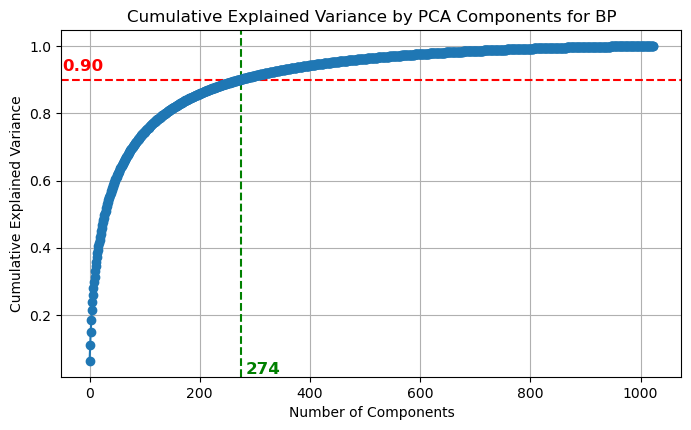

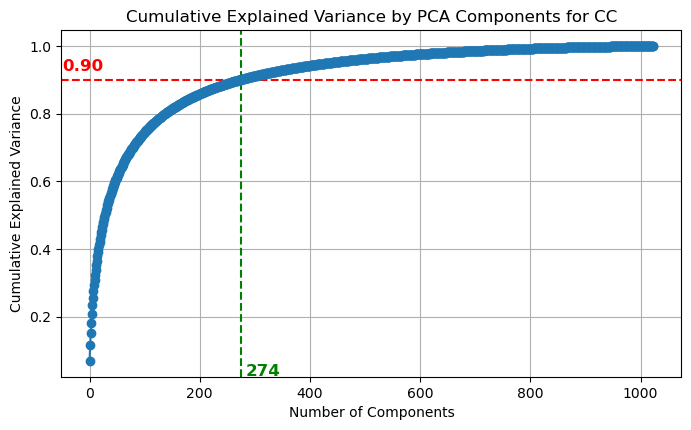

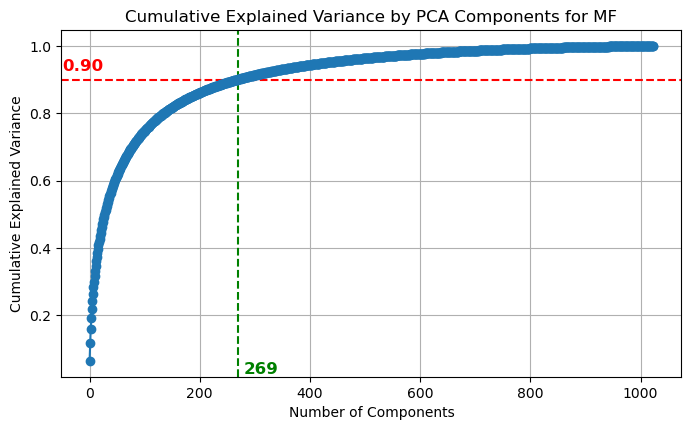

In [41]:
def pca_col(np_mat, name, column_name='embeddings', variance_threshold=0.90):    
    scaler = StandardScaler()
    embeddings_standardized = scaler.fit_transform(np_mat)
    
    pca = PCA()
    pca.fit(embeddings_standardized)
    explained_variance = pca.explained_variance_ratio_

    # Components to retain (in our case 90% of variance)
    n_components = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
        
    plt.figure(figsize=(8, 4.5))
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    x_value = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
    plt.axvline(x=x_value, color='g', linestyle='--')
    plt.text(x_value + 10, 0.025, f'{x_value}', color='green', size='large', weight='bold')
    plt.text(- 50, variance_threshold + 0.025, f'{variance_threshold:.2f}', color='red', size='large', weight='bold')

    plt.plot(np.cumsum(explained_variance), marker='o')
    plt.title(f'Cumulative Explained Variance by PCA Components for {name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings_standardized)
    
    return reduced_embeddings

# Apply PCA and add column for each dataset
x_remb_BP = pca_col(x_emb_BP, 'BP')
x_remb_CC = pca_col(x_emb_CC, 'CC')
x_remb_MF = pca_col(x_emb_MF, 'MF')

In [42]:
print(x_remb_BP.shape)

(83064, 274)


In [43]:
#export_numpy_array(x_remb_CC, 'x_remb_CC.npy')
#export_numpy_array(x_remb_MF, 'x_remb_MF.npy')
#export_numpy_array(x_remb_BP, 'x_remb_BP.npy')

# CC (Elia)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import csr_matrix  # For sparse matrix

# Load data
X = x_df_CC['reduced_embeddings']  # Assuming embeddings are already reduced
X = pd.DataFrame(X.tolist())  # Convert list of lists to DataFrame

# Convert to sparse matrix if data is sparse (this can speed up the process)
X_sparse = csr_matrix(X)

# Preprocess target (MultiLabelBinarizer for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_df_CC)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Train SGDClassifier with OneVsRestClassifier and parallel processing
sgd = OneVsRestClassifier(SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1, max_iter=100), n_jobs=-1, verbose=5)
sgd.fit(X_train, y_train)

# Evaluate
y_pred = sgd.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

KeyError: 'reduced_embeddings'